# Tracking Frequency, Phase, and Amplitude

In recent weeks, we have learned how to find the start of the signal and how to obtain initial estimates for amplitude, frequency, and phase errors. These initial estimates must be maintained throughout the reception of a signal frame. Of particular concern is a residual frequency error that leads to a build-up of phase error over time.

Today, we show how feedback control systems can be used to maintain accurate estimates - even if the true signal parameters are changing with time. The feedback control system for tracking the phase of the incoming signal is called a phase-locked loop.

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/070_tracking_loops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/070_tracking_loops.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

from typing import Tuple

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
def srrc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [6]:
def pop_count32(x: np.uint32) -> np.uint8:
    """count the number of 1s in 32-bit integer x using Wegner's method
    
    Inputs:
    x - a 32 bit integer

    Returns:
    an integer between 0 and 32 indicating the number of 1s in x
    """
    
    count: np.uint8 = 0
    
    while (x > 0):
        x = x & (x-1)
        count += 1
        
    return count

In [7]:
def lfsr_step(state: np.uint32, fb: np.uint32, N: int = 31) -> Tuple[np.uint8, np.uint32]:
    """Single update step of LFSR with feedback connections fb
    
    Inputs:
    * state (uint32): initial state of the feedback shift register
    * fb (uint32): bit map indicating feedback connections; the LSB corresponds to bit 0 in the LFSR
    * N (int) order if the LFSR; must be less than 32 (default: 31)
    
    Returns:
    * elem - next element of the LFSR sequence
    * state - updated state
    
    Example: Generate the first 10 elements of a LFSR sequence with fb=0b1001 and initial state=0b1111
    >>> state = 0b1111
    >>> seq = np.empty(10, dtype=np.uint8)
    >>> for n in range(10):
    >>>     seq[n], state = lfsr31_step(state, 0b1001)
    >>> seq
    
    array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)
    """
    
    # save the LSB before updating state; it will be returned
    elem: np.uint8 = state & 0b1
        
    # update state
    fb_vec: np.uint32 = state & fb
    fb_bit: np.uint8 = (pop_count32(fb_vec) & 0b1)
    
    # insert feedback bit at position N, then shift
    state = (state | fb_bit << N) >> 1
    
    return elem, state

In [8]:
def lfsr(init: np.uint32, fb: np.uint32, M: int, N: int = 31, Nc:int = 0):
    """Compute M samples of a LFSR sequence
    
    Inputs:
    init - initial state of the LFSR
    fb - feedback connection for the LFSR
    M - number of samples to generate
    N - order of the LFSR (default: 31)
    Nc - statrting sample (default 0)

    Returns:
    length-M vector of bits (stored as np.uint8)
    """
    seq = np.empty(M, dtype=np.uint8)

    state = init

    for n in range(Nc):
        _, state = lfsr_step(state, fb, N)          # discard the first Nc

    for n in range(M):  
        seq[n], state = lfsr_step(state, fb, N)     # keep the next Mc

    return seq

In [9]:
def est_freq(Z, pn, L=None):
    """Estimate frequency estimate from preamble samples

    Inputs:
    Z - matched filter outputs for preamble (taken at symbol period)
    pn - preamble sequence (same length as Z)
    L - spacing between samples to measure phase difference (default 2/3*K)

    Returns:
    float - frequency ofsset per symbol period
    """
    K = len(pn)

    if L is None:
        L = (2*K) // 3

    # make an array of all L-spaced phase differences
    dp = np.array( [ (pn[n+L]*Z[n+L]) * np.conj(pn[n]*Z[n]) for n in range(K-L) ] )

    return np.angle(np.mean(dp))/(2*L*np.pi)

## Phase-Locked Loops

A phase-locked loop aims to generate an estimate of the phase $\hat{\phi}[n]$ of the received signal $Z_n$; specifically, $Z_n$ is the output of the matched filter. It consists of three blocks

* The **phase detector** measures the phase difference between the incoming signal $Z_n$ and the phase estimate $\hat{\phi}[n]$. The phase detector can be further divided into 
    + a **phase rotator** that applies the phase correction $e^{-j\hat{\phi}[n]}$ to $Z_n$. The phase corrected signal $Z_n \cdot e^{-j\hat{\phi}[n]}$ is a suitable input to the decision rule.
    * The actual phase detection must strip any information symb $s_n$ from the output of the phase rotation, i.e., the phase detector computes the phase error $\Delta \phi$ as
    $$
    \Delta \phi[n] = \arg(\frac{Z_n \cdot e^{-j\hat{\phi}[n]}}{s_n}).
    $$
* The **loop filter** $H(z)$ scales and smoothes the phase errors $\Delta \phi[n]$.
* The **integrator** accumulates the filtered phase errors to produce the phase estimate $\hat{\phi}[n]$.

The loop will reach steady state when the phase errors $\Delta \phi[n]$ approach zero; i.e., when the phase estimates match the true phase of the incoming signal.

Since the PLL is stateful, i.e., it contains memory in its integrators, we will implement the PLL as a class; the state variable are stored as member variables.

### Loop Filters

We begin with classes for the first and second order loop filters.

#### First-Order Filter

In [10]:
class First_Order_Filter():
    """Class representing a first-order loop filter"""

    def __init__(self, alpha):
        """Initialize the gain of the filter
        
        Input:
        alpha - loop gain
        """
        self.alpha = alpha

    def __call__(self, d_n):
        """invoke the filter
        
        Input:
        d_n - single sample, representing error

        Returns:
        filtered sample; type is the same as the input
        """
        return self.alpha * d_n

    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, new_val):
        if new_val < 2 and new_val > 0:
            self._alpha = new_val
        else:
            raise ValueError("alpha = {:} makes PLL unstable".format(new_val))

In [11]:
# The class is used like this
H1 = First_Order_Filter(0.1)  # instantiate filter
assert 0.2 == H1(2)           # pass d_n=2 to filter, output sould be 0.2 
assert 0.1 == H1.alpha        # retrieve the value of alpha
H1.alpha = 0.2               # change the gain 
assert 0.2 == H1.alpha       # and check it

#### Second Order Filter

The second-order loop filter adds an integrator to the first order filter.

In [12]:
class Second_Order_Filter():
    """Class representing a second-order loop filter"""

    def __init__(self, alpha1, alpha2, state=0):
        """Initialize the gains and the state of the filter
        
        Input:
        alpha1 - linear gain
        alpha2 - integrator gain
        state - value helpd by integrator (optional, default: 0)
        """
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.state = state

    def __call__(self, d_n):
        """invoke the filter
        
        Input:
        d_n - single sample, representing error

        Returns:
        filtered sample; type is the same as the input
        """
        out = self.alpha1 * d_n + self.state
        self.state += self.alpha2 * d_n  # update state
        
        return out

    # below, we check that 0 <= alpha2 < alpha1 < 1
    @property
    def alpha1(self):
        return self._alpha1

    @alpha1.setter
    def alpha1(self, new_val):
        if new_val < 1 and new_val > 0:
            self._alpha1 = new_val
        else:
            raise ValueError("alpha1 = {:} can make PLL unstable".format(new_val))

    @property
    def alpha2(self):
        return self._alpha2

    @alpha2.setter
    def alpha2(self, new_val):
        if new_val < self._alpha1 and new_val > 0:
            self._alpha2 = new_val
        else:
            raise ValueError("alpha2 = {:} can make PLL unstable".format(new_val))

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

    @property
    def damping_factor(self):
        return self.alpha1 / 2 / np.sqrt(self.alpha2) 

In [13]:
# The class is used like this
H2 = Second_Order_Filter(0.1, 0.025)  # instantiate filter
assert 0.2 == H2(2)                   # pass d_n=2 to filter, output sould be 0.2 
assert 0.05 == H2.state               # check that state was updated
assert 0.25 == H2(2)                  # pass 2 again, this time state is not zero
assert 0.1 == H2.alpha1               # retrieve the value of alpha1
H2.alpha1 = 0.2                       # change the gain 
assert 0.2 == H2.alpha1               # and check it
assert 0.025 == H2.alpha2             # retrieve the value of alpha2
H2.alpha2 = 0.01                      # change the gain 
assert 0.01 == H2.alpha2              # and check it
H2.state = 0                          # set the state
assert 0 == H2.state                  # and check it

print("Damping factor is {:f}".format(H2.damping_factor))

Damping factor is 1.000000


### Integrator

The final stateful element in the PLL is the integrator.

In [14]:
class Integrator():
    """Class representing an integrator"""

    def __init__(self, state=0):
        self.state = state

    def __call__(self, x_n):
        "Compute the output from the integrator"
        out = self.state
        self.state += x_n

        return out

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

In [15]:
# quick check that this works: a sequence of 1's integrates into a ramp
S = Integrator()
x = np.ones(10)
y = np.zeros_like(x)
for n in range(10):
    y[n] = S(x[n])

assert np.allclose(y, np.arange(10))


### Phase Rotation

Phase rotation is a stateless operation. Hence, a function suffices.

In [16]:
def rotate_phase(Z_n, phi):
    """Rotate the phase of the input signal
    
    Inputs:
    Z_n - signal to be phase corrected
    phi - phase correction to apply

    Returns:
    complex sample
    """
    return Z_n * np.exp(-1j * phi)

### Phase Error

The final function measures the phase error between the received signal $Z_n$ and the phase estimate $\hat{\phi}[n]$; this is equivalent to measuring the residula phase error after applying the phase rotation.

However, before we can measure the phase error, any information symbols $s_n$ must be stripped off from the received signal $Z_n$.

In [17]:
def measure_phase(X_n, s_n=1):
    """measure the phase of modulated symbol 
    
    It is assumed that X_n = s_n * exp(j dphi) + N_n, where s_n is an information symbol
    and N_n is noise. The goal is to estimate the phase (error) dphi

    Inputs:
    X_n - sample of phase-rotated signal
    s_n - information symbol (default: 1)

    Returns:
    phase error estimate dphi
    """

    return np.angle(X_n / s_n)

### Putting it all together

We now have implementations of all components of the PLL. To test our implementation we will test it against a variety of signals with different phase errors.

We begin by setting parameters and allocating storage for results

In [18]:
# Parameters
alpha1 = 0.1
alpha2 = 0.004  # damping factor approximately 0.8

SNR_db = 20
SNR = 10**(SNR_db/10)

# for simplicity, we start with a signal of all 1's, i.e., zero phase
N = 200
s = np.ones(N, dtype=complex)

# storage for intermediate results
dphi = np.zeros_like(s, dtype=np.float64)  # phase error
phi = np.zeros_like(s, dtype=np.float64)   # phase estimate
state_H = np.zeros_like(phi)               # state of loop filter
x = np.zeros_like(s)                       # phase rotated input
y = np.zeros_like(s, dtype=np.float64)     # filter output

#### Response to a constant phase error

The first phase error that we investigate is a step error: the phase of the input signal is $\pi/2$. The PLL is expected to learn this phase error and compenstate it.

In [19]:
# define phase error
phase_error = np.pi/2 * np.ones(N)

# instantiate loop filter and integrator
H = Second_Order_Filter(alpha1, alpha2)
S = Integrator()

# make a received signal
Z = s * np.exp(1j * phase_error) + 1/np.sqrt(2*SNR) * (np.random.randn(N) + 1j * np.random.randn(N))

# run the PLL; intermediate signals are stored for analysis
for n in range(N):
    phi[n] = S.state
    x[n] = rotate_phase(Z[n], phi[n])
    dphi[n] = measure_phase(x[n], 1)
    y[n] = H(dphi[n])
    try:
        state_H[n] = H.state
    except AttributeError:
        pass
    S(y[n])  # pass filter output to integrator, we get the otput via S.state


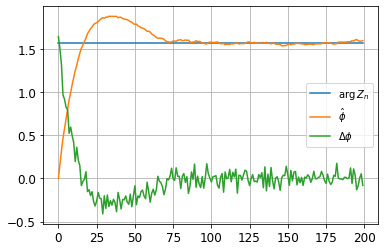

In [20]:
# plot phases
plt.plot(phase_error, label=r'$\arg Z_n$')
plt.plot(phi, label=r'$\hat{\phi}$')
plt.plot(dphi, label=r'$\Delta \phi$')

plt.grid()
plt.legend()

plt.show()

The estimated phase $\hat{\phi}$ converges to the true phase $\pi/2$.

Note also that the steady-state error is much smaller than the instantaneous phase error $\Delta \phi$.

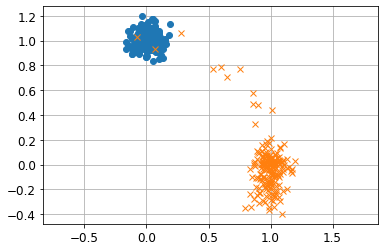

In [21]:
# Scatter plot of input before and after phase correcetion
plt.plot(Z.real, Z.imag, 'o', label='Before')
plt.plot(x.real, x.imag, 'x', label='After')
plt.grid()
plt.axis('equal')

plt.show()

After a few samples, the PLL succeeds in rotating the "constellation" to the correct location centered on the real axis.

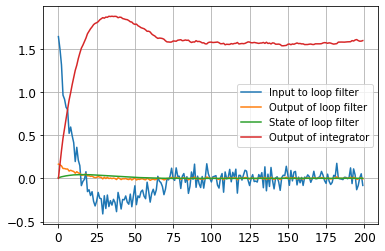

In [22]:
# plot internal signals
plt.plot(dphi, label="Input to loop filter")
plt.plot(y, label='Output of loop filter')
try:
    H.state
    plt.plot(state_H, label='State of loop filter')
except AttributeError:
    pass
plt.plot(phi, label='Output of integrator')

plt.grid()
plt.legend()
plt.show()

The output of the loop filter is a scaled and smoothed version of the input signal, i.e., the phase error $\Delta \phi$.

The state of the loop filter approaches zeros in steady state.

Recall that the output of the integrator (the phase estimate $\hat{\phi}$) is the obtained by integrating the output of the loop filter.

#### Response to a constant frequency error

The second phase error that we investigate is a ramp error: the phase of the input signal increases from $\pi/2$ to $\pi$ over the course of the observation. The (normalized) frequency offset is $\Delta f = \frac{1}{2\pi} \cdot \frac{\pi/2}{N} = \frac{1}{4N}$ per sample.

The second-order PLL is expected to learn this phase error and compenstate it.

In [23]:
# define phase error
phase_error = np.pi/2 * (1 + np.arange(N) / N)

# instantiate loop filter and integrator
H = Second_Order_Filter(alpha1, alpha2)
S = Integrator()

# make a received signal
Z = s * np.exp(1j * phase_error) + 1/np.sqrt(2*SNR) * (np.random.randn(N) + 1j * np.random.randn(N))

# run the PLL; intermediate signals are stored for analysis
for n in range(N):
    phi[n] = S.state
    x[n] = rotate_phase(Z[n], phi[n])
    dphi[n] = measure_phase(x[n], 1)
    y[n] = H(dphi[n])
    try:
        state_H[n] = H.state
    except AttributeError:
        pass
    S(y[n])

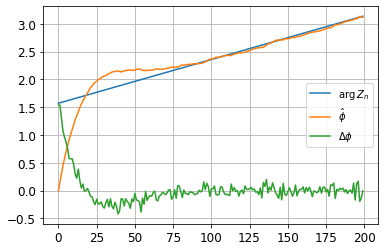

In [24]:
# plot phases
plt.plot(phase_error, label=r'$\arg Z_n$')
plt.plot(phi, label=r'$\hat{\phi}$')
plt.plot(dphi, label=r'$\Delta \phi$')

plt.grid()
plt.legend()

plt.show()

The estimated phase $\hat{\phi}$ rapidly converges to and tracks the phase of the input signal.

Again, the steady state error is much smaller than the instantaneous phase error.

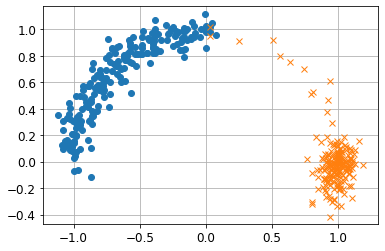

In [25]:
# Scatter plot of input before and after phase correcetion
plt.plot(Z.real, Z.imag, 'o', label='Before')
plt.plot(x.real, x.imag, 'x', label='After')
plt.grid()
plt.axis('equal')

plt.show()

After a few samples, the rotated "constellation" is centered correctly on the real axis.

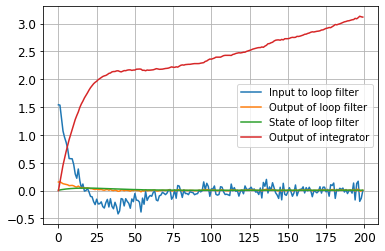

In [26]:
# plot internal signals
plt.plot(dphi, label="Input to loop filter")
plt.plot(y, label='Output of loop filter')
try:
    H.state
    plt.plot(state_H, label='State of loop filter')
except AttributeError:
    pass
plt.plot(phi, label='Output of integrator')

plt.grid()
plt.legend()
plt.show()

While the phase error (i.e., the input to the loop filter) approaches zero in state state, the output of the filter and the state of the filter do **not** approach zero. This is easier to see when the other signals are removed.

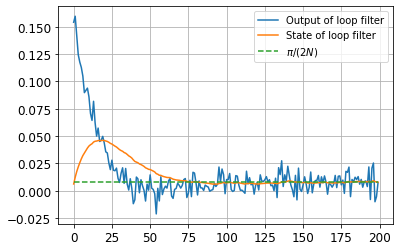

In [27]:
# close-up of loop-filter signals
plt.plot(y, label='Output of loop filter')
try:
    H.state
    plt.plot(state_H, label='State of loop filter')
except AttributeError:
    pass

plt.plot(np.arange(N), np.pi/2/N*np.ones(N), '--', label=r'$\pi/(2N)$')

plt.grid()
plt.legend()
plt.show()

The output of the loop filter and the state of the loop filter do not converge to zero when there is a frequency offset.

In fact, the state of the second-order loop filter approaches $2\pi \Delta f$ (i.e,. $\pi/(2N)$) in this case. This is the phase increase between consecutive samples in the input signal.

#### Response to a time-varying frequency error

The final phase error that we investigate is a time-varying error: the phase of the input signal oscillates between $0$ and $\pi$ with a period equal to the length of the observation. The instantaneous normalized frequency of this signal varies between $\Delta f_{max} = \pi/(N)$ initial to $-\Delta f_{max} = -\pi/(N)$ per sample.

This is an extreme scenario that is unlikely to occur in practice. For example, if the symbol rate were 1MHz, then the frequency offset would change from 2.5KHz to -2.5KHz over a span of 100$\mu$s. As such, this experiment is intnded to serve as a stress test.

Still, the second-order PLL is expected to track this error fairly closely. However, it will not be able to eliminate t completely.

In [28]:
# define phase error
#phase_error = np.pi/2 * (1 + np.sin(np.pi*np.arange(N)/N))
phase_error = 2*np.pi/2 * (0 + np.sin(2*np.pi*np.arange(N)/N))

# instantiate loop filter and integrator
H = Second_Order_Filter(alpha1, alpha2)
S = Integrator()

# make a received signal
Z = s * np.exp(1j * phase_error) + 1/np.sqrt(2*SNR) * (np.random.randn(N) + 1j * np.random.randn(N))

# run the PLL; intermediate signals are stored for analysis
for n in range(N):
    phi[n] = S.state
    x[n] = rotate_phase(Z[n], phi[n])
    dphi[n] = measure_phase(x[n], 1)
    y[n] = H(dphi[n])
    try:
        state_H[n] = H.state
    except AttributeError:
        pass
    S(y[n])

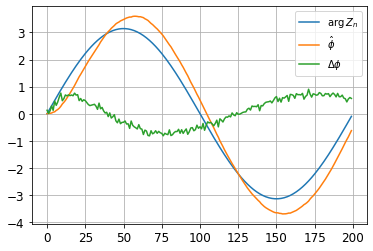

In [29]:
# plot phases
plt.plot(phase_error, label=r'$\arg Z_n$')
plt.plot(phi, label=r'$\hat{\phi}$')
plt.plot(dphi, label=r'$\Delta \phi$')

plt.grid()
plt.legend()

plt.show()

The estimated phase follows the true phase, but it never quite catches up.

As a result, the phase error does not approach zero.

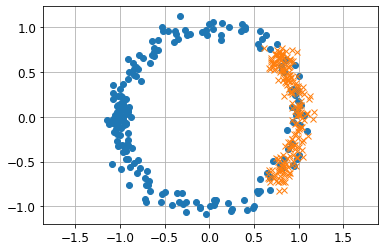

In [30]:
# Scatter plot of input before and after phase correcetion
plt.plot(Z.real, Z.imag, 'o', label='Before')
plt.plot(x.real, x.imag, 'x', label='After')
plt.grid()
plt.axis('equal')

plt.show()

While the corrected "constellation" is closer to the correct solution on the real axis, there remains considerable phase error.

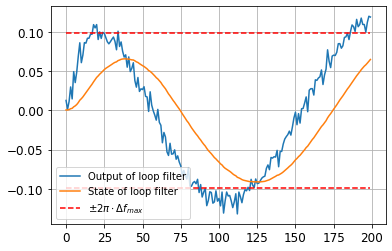

In [31]:
# close-up of loop-filter signals
plt.plot(y, label='Output of loop filter')
try:
    H.state
    plt.plot(state_H, label='State of loop filter')
except AttributeError:
    pass
plt.plot(np.arange(N), 2*(np.pi)**2/N*np.ones(N), 'r--', label=r'$\pm 2\pi \cdot \Delta f_{max}$')
plt.plot(np.arange(N), -2*(np.pi)**2/N*np.ones(N), 'r--')
plt.grid()
plt.legend(loc='lower left')
plt.show()

The internal signals reflect the frequency variation. In particular, the state of the loop filter approaches the instantaneous frequency of the received signal.

## Amplitude Tracking

We have looked closely at tracking the phase of the received signal. In practice, we also need to maintain the amplitude of the received signal. This is critical for scaling the constellation correctly.

The tracking loop discussed above can be used for this purpose as long as we replace the phase detector with a device that measures the amplitude error. We need to make the following changes:

* The variable to be tracked by the loop is the inverse $\gamma$ of amplitude $A$ (i.e., $gamma = 1/A$) instead of $\phi$. Our  estimate is denoted $\hat{\gamma}$.
* Instead of phase rotation, we need to scale the amplitude of the received signal. For that purpose, the received samples $Z_n$ are multiplied by $\hat{\gamma}$.
* To measure the amplitude error, we can use the metric $1-\frac{|Z_n|}{|s_n|}$, where $s_n$ is the information symbol during period $n$.

Thus, we need two additional functions for the amplitude tracking loop.

In [32]:
def scale_amplitude(Z_n, gamma):
    """Scale the amplitude of the input signal
    
    Inputs:
    Z_n - signal to be phase corrected
    gamma - amplitude correction to apply

    Returns:
    complex sample
    """
    return Z_n * gamma

In [33]:
def measure_amplitude_error(X_n, s_n=1):
    """measure the amplitude error of modulated symbol 
    
    It is assumed that X_n = s_n * A + N_n, where s_n is an information symbol
    and N_n is noise. The goal is to estimate the gain gamma such that A * gamma = 1

    Inputs:
    X_n - sample of phase-rotated signal
    s_n - information symbol (default: 1)

    Returns:
    amplitude error estimate dA
    """

    return 1 - np.abs(X_n / s_n)

### Putting it together

We now have implementations of the components for the amplitude tracking loop. The loop filters and the integrator from the PLL can be re-used without change. 

The amplitude is not expected to change (much) over time. Hence, a first-order loop should suffice.

We begin by setting parameters and allocating storage for results

In [34]:
# Parameters
alpha = 0.1

SNR_db = 20
SNR = 10**(SNR_db/10)

# for simplicity, we start with a signal of all 1's, i.e., unit amplitude
N = 200
s = np.ones(N, dtype=complex)

# storage for intermediate results
dA = np.zeros_like(s, dtype=np.float64)    # amplitude error
gamma = np.zeros_like(s, dtype=np.float64) # estimate of 1/A
x = np.zeros_like(s)                       # amplitude scaled input
y = np.zeros_like(s, dtype=np.float64)     # filter output

In [35]:
# define amplitude error
amplitude_error = 1.5 * np.ones(N)

# instantiate loop filter and integrator
H = First_Order_Filter(alpha)
S = Integrator()

# make a received signal
Z = s * amplitude_error + 1/np.sqrt(2*SNR) * (np.random.randn(N) + 1j * np.random.randn(N))

# run the PLL; intermediate signals are stored for analysis
for n in range(N):
    gamma[n] = S.state
    x[n] = scale_amplitude(Z[n], gamma[n])
    dA[n] = measure_amplitude_error(x[n], 1)
    y[n] = H(dA[n])
    S(y[n])

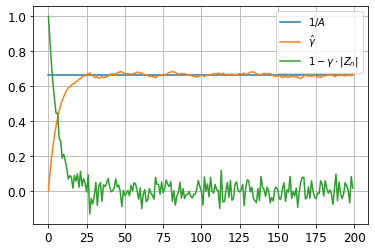

In [36]:
# plot amplitudes
plt.plot(1/amplitude_error, label=r'$1/A$')
plt.plot(gamma, label=r'$\hat{\gamma}$')
plt.plot(dA, label=r'$1 - \gamma \cdot |Z_n|$')

plt.grid()
plt.legend()

plt.show()

## Tracking Phase and Amplitude

The two tracking loops works completely independent of each other. Hence, we can run the two loops either in parallel or in series.

For each sample, we will first perform phase correction and then amplitude correction:

1.  pass the matched filter outputs $Z_n$ to the PLL,
2. the pase correceted input $Z[n] \cdot e^{-j\phi[n]}$ is passed to the amplitude tracking loop,
3. the amplitude corrected input $\hat{\gamma} \cdot Z[n] \cdot e^{-j\phi[n]}$ is a suitable input to the decision rule.

Below is an illustration of the overall process.


In [37]:
# Parameters
alpha = 0.1     # gain for amplitude loop
alpha1 = 0.1    # gains for phase loop
alpha2 = 0.004

SNR_db = 20
SNR = 10**(SNR_db/10)

# for simplicity, we start with a signal of all 1's, i.e., unit amplitude
N = 200
s = np.ones(N, dtype=complex)

# storage for intermediate results
dphi = np.zeros_like(s, dtype=np.float64)    # phase error
phi = np.zeros_like(s, dtype=np.float64)     # phase estimate
dA = np.zeros_like(s, dtype=np.float64)      # amplitude error
gamma = np.zeros_like(s, dtype=np.float64)   # estimate of 1/A
x = np.zeros_like(s)                         # phase corrected input
y = np.zeros_like(s)                         # amplitude and phase corrected input

In [38]:
# define amplitude error
amplitude_error = 1.5 * np.ones(N)
phase_error = np.pi/2 * (1 + np.arange(N) / N)

# instantiate loop filters and integrators, one for each loop
HA = First_Order_Filter(alpha)
SA = Integrator()

HP = Second_Order_Filter(alpha1, alpha2)
SP = Integrator()

# make a received signal with both amplitude and phase error
Z = s * amplitude_error * np.exp(1j * phase_error) + 1/np.sqrt(2*SNR) * (np.random.randn(N) + 1j * np.random.randn(N))

# run the tracking loops
for n in range(N):
    # first the PLL
    phi[n] = SP.state
    x[n] = rotate_phase(Z[n], phi[n])        # this goes to amplitude loop
    dphi[n] = measure_phase(x[n], 1)
    tmp = HP(dphi[n])
    SP(tmp)

    # then the amplitude loop, input is the phase correceted input x[n]
    gamma[n] = SA.state
    y[n] = scale_amplitude(x[n], gamma[n])   # this is the input from above
    dA[n] = measure_amplitude_error(y[n], 1)  
    tmp = HA(dA[n])
    SA(tmp)


The two loops are executed sequentially; each sample $Z_n$ is first passed to the phase tracking loop. Then, the corrected phase is passed to amplitude tracking.

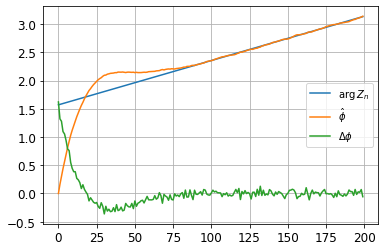

In [39]:
# plot phases
plt.plot(phase_error, label=r'$\arg Z_n$')
plt.plot(phi, label=r'$\hat{\phi}$')
plt.plot(dphi, label=r'$\Delta \phi$')

plt.grid()
plt.legend()

plt.show()

The phase loop converges as before.

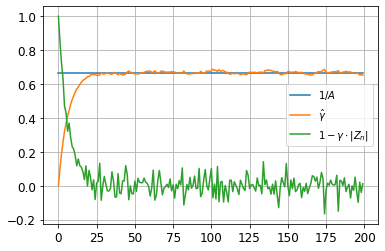

In [40]:
# plot amplitudes
plt.plot(1/amplitude_error, label=r'$1/A$')
plt.plot(gamma, label=r'$\hat{\gamma}$')
plt.plot(dA, label=r'$1 - \gamma \cdot |Z_n|$')

plt.grid()
plt.legend()

plt.show()

And, the amplitude loop converges, too.

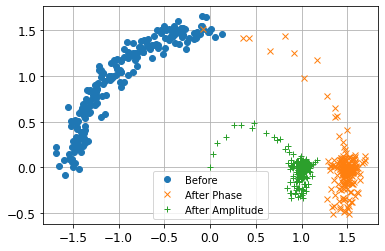

In [41]:
# Scatter plot of input before and after phase and amplitude correcetions
plt.plot(Z.real, Z.imag, 'o', label='Before')
plt.plot(x.real, x.imag, 'x', label='After Phase')
plt.plot(y.real, y.imag, '+', label='After Amplitude')
plt.grid()
plt.axis('equal')
plt.legend()
plt.show()

The corrections lead to the "constellation" being scaled and rotated correctly. The green symbols are centered correctly at $1+j0$ on the real axis.

## The complete acquisition and tracking process

Last week we investigated the initial estimation of amplitude frequency and phase by means of the preamble signal.

Today, we illustrated how tracking loops can maintain good estimates of these parameters.

We can combine the two processes by using the initial estimates to initialize the state of the tracking loops:

* the initial amplitude estimate $\hat{A}$ should be the initial state of the integrator in the frequency tracking loop.
* the initial frequency offset estimate $\hat{\Delta f}$ initializes the state of the second-order loop filter in the phase tracking loop.
* for the initial phase estimate, we distinguish two cases:
    1. if the tracking loop starts with the first sample of the preamble, then the state of the integrator in the phase tracking loop is initialized to the phase estimate $\hat{\phi}$
    2. if tracking is to start with the first sample of the payload, then the state of that integrator must be initialized to $\hat{\phi} + 2\pi N_p \hat{\Delta f}$.

We illustrate the complete process below:

### Generate a signal

The code from last week is re-used to generate a preamble signal followed by a payload.

In [42]:
## construct a suitable training signal followed by information symbols
# Parameters
fsT = 32    # tx oversampling
K = 31      # length of preamble
fb = 5      # LFSR feedback

Ap = np.array([1.0, -1.0], dtype=complex) # BPSK for preamble
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK for info
Ns = 1024     # number of information symbols

hh = srrc_pulse(0.5, fsT)

# make preamble symbols and info symbols, then concatenate
pn = Ap[lfsr(1, fb, K, 5)]
syms = random_symbols(A, Ns)

sig = pulse_shape(np.concatenate((pn, syms)), hh, fsT)

### Channel

The channel introduces a a phase and frequency offset and scales the amplitude.

AWGN is added to generate the received signal

In [43]:
## channel parameters
delay_samples = 102
ds_factor = 4       # down-sample by 4

df = 0.1/(fsT*(K-1))  # frequency offset per symbol period, phase change is 0.1*2*pi over course of preamble
X = 0.5*np.exp(1j*np.pi/4) # amplitude and phase

# delay by pre-pending zeros
rr = np.concatenate(( np.zeros(delay_samples), X * sig * np.exp(2j * np.pi * df * np.arange(len(sig))) ))

# down-sample
rr = rr[::ds_factor]
fsT_r = fsT // ds_factor

SNR_dB = 20
SNR = 10**(SNR_dB/10)
noise_var = abs(X)**2 / SNR 

# the down-sampled signal should have higher amplitude  
rr = np.sqrt(ds_factor)*rr + np.sqrt(0.5 * noise_var) * (np.random.randn(len(rr)) + 1j*np.random.randn(len(rr))) 

### Receiver Processing

Processing in the receiver includes

* matched filtering,
* locating the preamble, including the best sampling phase,
* followed by initial parameter estimates derived from the preamble.

#### Matched Filter

In [44]:
## matched filter
hh_r = srrc_pulse(0.5, fsT_r)  # filter for reduced sampling rate
mf_out = np.convolve(rr, np.flip(hh_r))

## divide MF output into fsT_r sampling phases
nT = len(mf_out) // fsT_r  # number of symbol periods for each phase
Z = np.zeros((fsT_r, nT), dtype=complex)
for n in range(fsT_r):
    Z[n, :] = mf_out[n : fsT_r*nT : fsT_r]

#### Preamble Processing

In [45]:
## correlate against the preamble sequence and locate preamble 
D = np.zeros((fsT_r, nT + K - 1), dtype=complex)

for n in range(fsT_r):
    D[n, :] = np.convolve(Z[n,:], np.flip(np.conj(pn)))

# locate the tallest peak in the correlation
max_n = np.argmax(np.abs(D[:, :])**2, axis=1)
max_i = np.argmax(np.array([np.abs(D[n, max_n[n]])**2 for n in range(fsT_r)]))
n_hat = max_n[max_i]
i_hat = max_i

first = n_hat - K + 1
last = n_hat + 1

print("Preamble start in period {:d}, best sampling phase {:d}". format(first, i_hat))

Preamble start in period 13, best sampling phase 1


In [46]:
## Estimate the frequency offset
f_hat = est_freq(Z[i_hat, first:n_hat+1], pn)

# display result
print('Estimated frequency offset: {:6.5f} (per T)'.format(f_hat))
print('phase change during preamble: {:4.3f} *2pi (True: {:4.1f} *2pi)'.format((K-1)*f_hat, 0.1))

Estimated frequency offset: 0.00338 (per T)
phase change during preamble: 0.101 *2pi (True:  0.1 *2pi)


In [47]:
## Estimate amplitude and phase
# apply frequency correction
Z_corr = Z[i_hat,first:n_hat+1] * np.exp(-2j * np.pi * f_hat * np.arange(K)) 
# strip of the preamble symbols
ZZ_corr_pn = Z_corr * pn.conj()
# form the estimate
X_hat = np.sum(ZZ_corr_pn) / np.sum(np.abs(pn)**2)

print("Estimated amplitude: {:4.3f}\nEstimated phase: {:4.3f} * pi".format(np.abs(X_hat), 
                                                                           np.angle(X_hat)/np.pi))
print("Corrected phasor X/X_hat = {:4.3f} + j {:4.3f}". format(np.real(X/X_hat), np.imag(X/X_hat)))

Estimated amplitude: 0.489
Estimated phase: 0.283 * pi
Corrected phasor X/X_hat = 1.017 + j -0.106


### Tracking loops

We choose to start our tracking loops with the preamble. For that purpose, we
* initialize the states of the integrators in the loop
* then run the loops using the known training symbols

#### Initialize the tracking loops using the preamble

In [48]:
# pull out preamble sample and allocate storage for intermediate results
Z_hat = Z[i_hat, first:first+K]                  # <- this is the input signal to the loop
dphi = np.zeros_like(Z_hat, dtype=np.float64)    # phase error
phi = np.zeros_like(Z_hat, dtype=np.float64)     # phase estimate
dA = np.zeros_like(Z_hat, dtype=np.float64)      # amplitude error
gamma = np.zeros_like(Z_hat, dtype=np.float64)   # estimate of 1/A
x = np.zeros_like(Z_hat)                         # phase corrected input
y = np.zeros_like(Z_hat)                         # amplitude and phase corrected input

In [49]:
# instantiate loop filters and integrators, one for each loop
HA = First_Order_Filter(alpha)
SA = Integrator()
SA.state = 1/np.abs(X_hat)  # initialize amplitude loop with 1/amplitude estimate

HP = Second_Order_Filter(alpha1, alpha2)
SP = Integrator()
SP.state = np.angle(X_hat)  # initialize phase loop with phase estimate
HP.state = 2*np.pi*f_hat    # and frequency estimate

## now run the tracking loop over the preamble symbols (length K)
for n in range(K):
    # first the PLL
    phi[n] = SP.state
    x[n] = rotate_phase(Z_hat[n], phi[n])        # this goes to amplitude loop
    dphi[n] = measure_phase(x[n], pn[n])
    tmp = HP(dphi[n])
    SP(tmp)

    # then the amplitude loop, input is the phase correceted input x[n]
    gamma[n] = SA.state
    y[n] = scale_amplitude(x[n], gamma[n])   # x[n] is the input from above
    dA[n] = measure_amplitude_error(y[n], pn[n])  
    tmp = HA(dA[n])
    SA(tmp)
    

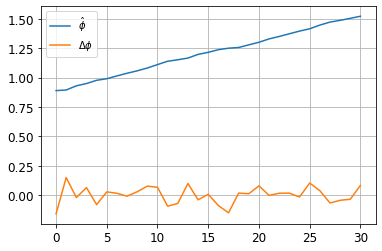

In [50]:
# plot phases
plt.plot(phi, label=r'$\hat{\phi}$')
plt.plot(dphi, label=r'$\Delta \phi$')

plt.grid()
plt.legend()

plt.show()

By using the initial estimates for phase and frequency, the phase errors are near zero from the beginning; the transient is avoided.

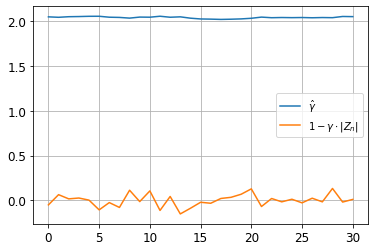

In [51]:
# plot amplitudes
plt.plot(gamma, label=r'$\hat{\gamma}$')
plt.plot(dA, label=r'$1 - \gamma \cdot |Z_n|$')

plt.grid()
plt.legend()

plt.show()

The same observation applies to the amplitude tracking loop.

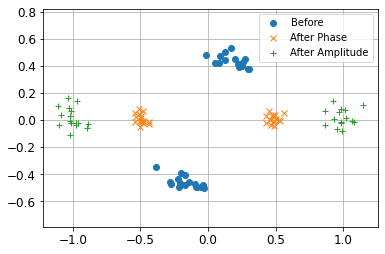

In [52]:
# Scatter plot of input before and after phase and amplitude correcetions
plt.plot(Z_hat.real, Z_hat.imag, 'o', label='Before')
plt.plot(x.real, x.imag, 'x', label='After Phase')
plt.plot(y.real, y.imag, '+', label='After Amplitude')
plt.grid()
plt.axis('equal')
plt.legend()
plt.show()

#### Using the tracking loop to demodulate symbols

Now that the tracking loops are "warmed up" we can use them during the symbol modulation phase. Again, we have two options.

1. We can turn off (set to zero) any further inputs to the loops; this is equivalent to applying corrections according to the most recent estimates reflected in the state variables of the loops.
2. We can continue to update the state of the loop. In place of the training symbols $p[n]$, we would need to use *symbol decisions* during phase and amplitude measurements.

The second approach is illustrated below.

In [53]:
# pull out information bearing samples and allocate storage for intermediate results
Z_hat = Z[i_hat, first+K:first+K+Ns]             # <- this is the input signal to the loop
dphi = np.zeros_like(Z_hat, dtype=np.float64)    # phase error
phi = np.zeros_like(Z_hat, dtype=np.float64)     # phase estimate
dA = np.zeros_like(Z_hat, dtype=np.float64)      # amplitude error
gamma = np.zeros_like(Z_hat, dtype=np.float64)   # estimate of 1/A
x = np.zeros_like(Z_hat)                         # phase corrected input
y = np.zeros_like(Z_hat)                         # amplitude and phase corrected input
dec = np.zeros_like(Z_hat)                       # symbol decisions

In [54]:
## DO NOT modify the state of the tracking loops!!

## run the tracking loop over the information symbols (length Ns)
for n in range(Ns):
    # perform phase and amplitude corrections
    phi[n] = SP.state
    x[n] = rotate_phase(Z_hat[n], phi[n])        # this goes to amplitude loop
    gamma[n] = SA.state
    y[n] = scale_amplitude(x[n], gamma[n])       # this goes to the decision rule

    dec[n] = MPE_decision_rule([y[n]], A)

    dphi[n] = measure_phase(x[n], dec[n])       # decison feedback
    tmp = HP(dphi[n])
    SP(tmp)

    # then the amplitude loop, input is the phase correceted input x[n]
    dA[n] = measure_amplitude_error(y[n], dec[n]) # decision feedback 
    tmp = HA(dA[n])
    SA(tmp)

print("Found {:d} errors".format(np.sum(np.not_equal(dec, syms))))
    

Found 0 errors


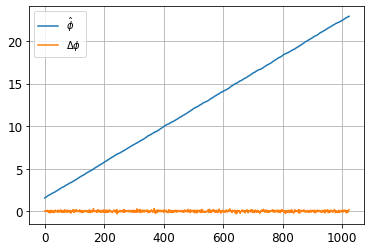

In [55]:
# plot phases
plt.plot(phi, label=r'$\hat{\phi}$')
plt.plot(dphi, label=r'$\Delta \phi$')

plt.grid()
plt.legend()

plt.show()

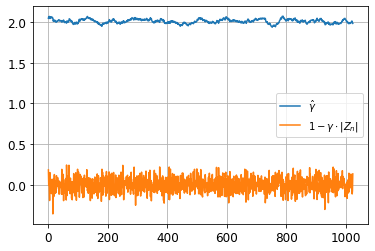

In [56]:
# plot amplitudes
plt.plot(gamma, label=r'$\hat{\gamma}$')
plt.plot(dA, label=r'$1 - \gamma \cdot |Z_n|$')

plt.grid()
plt.legend()

plt.show()

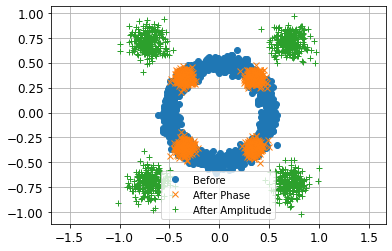

In [57]:
# Scatter plot of input before and after phase and amplitude correcetions
plt.plot(Z_hat.real, Z_hat.imag, 'o', label='Before')
plt.plot(x.real, x.imag, 'x', label='After Phase')
plt.plot(y.real, y.imag, '+', label='After Amplitude')
plt.grid()
plt.axis('equal')
plt.legend()
plt.show()

## Summary

We have illustrated how tracking loops can be used to maintain accut=rate estimates of amplitude, frequency, and phase - even if these parameters vary over time.

In combination with the initial estimates obtained from the preamble, the tracking loops provide the accurate parameters needed to successfully demodulate symbols in the face of unknown and/or time-varying channel parameters.